# 📚 Laboratorio 1: Datos No Estructurados - Procesamiento de Video con Python

**Asignatura:** Big Data  
**Autores:** Juan Gerardo Mendez, David Gomez, Santiago Cardona

**Fecha:** Abril de 2025  

---

## 🧩 Tecnologías y Librerías Utilizadas

- Python 3.10
- OpenCV
- DeepFace
- Matplotlib
- Pandas
- NumPy
- scikit-learn
- ffmpeg-python

---

## Pasos Desarrollados

### 1. Recopilación de Datos

Se utilizaron 3 trailers:

- `HacksawRidge.mp4`
- `ToyStory.mp4`
- `Superbad.mp4`

### 2. Procesamiento de Video

- Análisis de color promedio por video.
- Cálculo del movimiento promedio entre frames.
- Densidad de rostros (número de caras detectadas por segundo).
- Extracción de energía de audio usando FFmpeg.
- Análisis de emociones frame por frame.

### 3. Clasificación Automática

- Entrenamiento de un modelo **Random Forest** personalizado.
- Se usaron como features:
  - Color promedio (`r`, `g`, `b`)
  - Movimiento promedio (`avg_movement`)
  - Emoción dominante (`dominant_emotion`)
  - Energía de audio (`audio_energy`)
  - Densidad de caras (`face_density`)

---

## 🛠️ Implementaciones Destacadas

| Módulo                         | Descripción |
|:-------------------------------|:------------|
| `analyze_dominant_color()`      | Extrae color promedio del video. |
| `analyze_video_movement()`      | Calcula el movimiento entre frames. |
| `analyze_audio_energy()`        | Analiza volumen promedio del audio. |
| `calculate_face_density()`      | Mide cuántas caras aparecen por segundo. |
| `analyze_video_and_write_output()` | Analiza emociones en cada frame y genera un nuevo video anotado. |
| `train_genre_classifier()`      | Entrena el modelo de predicción de géneros. |
| `predict_genre_with_model()`    | Predice el género del trailer procesado. |


In [255]:
pip install opencv-python deepface matplotlib pandas ffmpeg-python numpy scikit-learn moviepy

Note: you may need to restart the kernel to use updated packages.


In [5]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from deepface import DeepFace
import ffmpeg

from moviepy import VideoFileClip

In [6]:
def analyze_video_and_write_output(input_path, output_path="output_emotion_video.mp4", frame_sample_rate=30):
    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    emotion_data = []

    print(f"Processing {total_frames} frames...")

    i = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if i % frame_sample_rate == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5)

            for (x, y, w, h) in faces:
                if w < 30 or h < 30:
                    continue

                face_crop = frame[y:y+h, x:x+w]
                face_crop = cv2.resize(face_crop, (224, 224))

                try:
                    result = DeepFace.analyze(
                        face_crop, 
                        actions=["emotion"], 
                        enforce_detection=False,
                        detector_backend="retinaface"
                    )
                    dominant_emotion = result[0]["dominant_emotion"]
                    emotion_data.append(result[0]["emotion"])

                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    cv2.putText(frame, dominant_emotion, (x, y - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

                except Exception as e:
                    print(f"Frame {i}: error analyzing face – {e}")
                    continue

        out.write(frame)

        if i % 60 == 0:
            print(f"Processed frame {i}/{total_frames}")

        i += 1

    cap.release()
    out.release()
    print(f"✅ Video saved at: {output_path}")

    if emotion_data:
        df_emotions = pd.DataFrame(emotion_data)
        avg_emotions = df_emotions.mean()
        print("\n=== Emotion Averages ===")
        print(avg_emotions)
        return avg_emotions
    else:
        print("⚠️ No emotion data was collected.")
        return None


In [7]:
def analyze_dominant_color(video_path, sample_rate_seconds=5):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps

    print(f"Video duration: {duration:.2f} seconds")

    timestamps = list(range(0, int(duration), sample_rate_seconds))
    avg_colors = []

    for second in timestamps:
        cap.set(cv2.CAP_PROP_POS_MSEC, second * 1000)
        ret, frame = cap.read()
        if not ret:
            continue

        # Resize to make processing faster
        frame_small = cv2.resize(frame, (100, 100))
        
        # Average color in BGR
        avg_color_per_row = np.average(frame_small, axis=0)
        avg_color = np.average(avg_color_per_row, axis=0)
        avg_colors.append(avg_color)  # BGR format

    cap.release()

    avg_colors = np.array(avg_colors)

    # Average across all sampled frames
    mean_color_bgr = np.mean(avg_colors, axis=0)

    # Convert BGR to RGB correctly
    mean_color_rgb = mean_color_bgr[::-1]

    print(f"Average color (RGB): {mean_color_rgb}")

    color_square = np.ones((100, 100, 3), dtype=np.uint8)
    color_square[:, :] = np.clip(mean_color_rgb, 0, 255).astype(np.uint8)

    plt.imshow(color_square)
    plt.title(f"Average Color of Video")
    plt.axis('off')
    plt.show()

    return mean_color_rgb

In [8]:
def analyze_video_movement(video_path, sample_rate_frames=5):
    cap = cv2.VideoCapture(video_path)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames: {total_frames}")

    prev_gray = None
    movement_scores = []

    for i in range(0, total_frames, sample_rate_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if prev_gray is not None:
            diff = cv2.absdiff(prev_gray, gray)
            score = np.sum(diff) / diff.size  
            movement_scores.append(score)

        prev_gray = gray

    cap.release()

    if len(movement_scores) == 0:
        print("⚠️ No movement data collected.")
        return 0

    avg_movement = np.mean(movement_scores)
    print(f"Average movement score: {avg_movement}")

    return avg_movement


In [9]:
def analyze_audio_energy(video_path):
    try:
        clip = VideoFileClip(video_path)

        if clip.audio is None:
            print("⚠️ No audio track found.")
            return 0.0

        # Extract audio as an array
        audio_array = clip.audio.to_soundarray(fps=44100) 
        
        if audio_array.ndim == 2:
            audio_array = audio_array.mean(axis=1)

        # Calculate RMS (Root Mean Square) energy
        audio_energy = np.sqrt(np.mean(audio_array**2))

        print(f"Audio Energy: {audio_energy:.4f}")
        return audio_energy

    except Exception as e:
        print(f"⚠️ Error analyzing audio: {e}")
        return 0.0


In [20]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def calculate_face_density(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps

    face_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
        face_count += len(faces)

    cap.release()

    face_density = face_count / duration  
    return face_density

In [11]:
def train_genre_classifier():
    data = {
        "r": [
            70, 180, 120, 50, 250, 90, 40, 210, 200, 80,
            100, 60, 160, 150, 130, 180, 100, 70, 90, 60,
            220, 230, 240, 200, 210, 90, 80, 75, 85, 65,
            60, 70, 55, 45, 80, 90, 100, 110, 70, 80,
            180, 170, 190, 200, 210, 220, 120, 130, 140, 150
        ],
        "g": [
            70, 60, 140, 60, 200, 110, 60, 170, 180, 60,
            80, 50, 140, 130, 110, 190, 120, 80, 100, 70,
            230, 220, 210, 200, 190, 110, 100, 95, 105, 85,
            60, 75, 55, 45, 90, 100, 110, 120, 75, 85,
            160, 150, 170, 180, 190, 200, 140, 130, 120, 110
        ],
        "b": [
            90, 50, 100, 50, 180, 130, 70, 160, 170, 70,
            90, 60, 120, 110, 90, 170, 100, 90, 110, 80,
            240, 250, 230, 220, 210, 130, 120, 115, 125, 105,
            70, 85, 65, 55, 100, 110, 120, 130, 85, 95,
            140, 130, 150, 160, 170, 180, 110, 100, 90, 80
        ],
        "avg_movement": [
            15, 20, 10, 5, 22, 18, 7, 21, 19, 6,
            12, 8, 17, 16, 9, 23, 11, 7, 13, 9,
            20, 18, 21, 19, 22, 10, 11, 9, 12, 8,
            7, 6, 5, 4, 15, 16, 17, 18, 6, 8,
            21, 20, 22, 23, 24, 25, 13, 14, 15, 16
        ],
        "dominant_emotion": [
            3, 2, 5, 4, 1, 5, 4, 2, 1, 3,
            3, 4, 2, 4, 5, 1, 3, 4, 3, 5,
            1, 2, 3, 4, 5, 2, 1, 5, 4, 3,
            2, 1, 5, 4, 3, 2, 1, 5, 4, 3,
            1, 2, 3, 4, 5, 1, 2, 3, 4, 5
        ],
        "audio_energy": [
            0.22, 0.48, 0.30, 0.10, 0.50, 0.28, 0.09, 0.45, 0.42, 0.12,
            0.24, 0.18, 0.39, 0.36, 0.20, 0.49, 0.25, 0.14, 0.26, 0.17,
            0.48, 0.47, 0.50, 0.45, 0.49, 0.32, 0.31, 0.33, 0.30, 0.29,
            0.28, 0.27, 0.26, 0.25, 0.35, 0.34, 0.33, 0.32, 0.24, 0.23,
            0.50, 0.49, 0.48, 0.47, 0.46, 0.45, 0.36, 0.35, 0.34, 0.33
        ],
        "face_density": [
            1.2, 1.5, 1.8, 0.4, 1.7, 1.3, 0.5, 1.6, 1.4, 0.6,
            1.0, 0.8, 1.5, 1.7, 0.9, 1.9, 1.1, 0.7, 1.2, 0.8,
            2.1, 2.3, 2.0, 1.8, 2.2, 1.1, 1.3, 1.4, 1.2, 1.5,
            0.6, 0.7, 0.8, 0.9, 1.7, 1.6, 1.5, 1.4, 0.7, 0.9,
            2.4, 2.3, 2.2, 2.1, 2.0, 1.9, 1.5, 1.4, 1.3, 1.2
        ],
        "genre": [
            "Action", "Action", "Animation", "Drama", "Action",
            "Comedy", "Drama", "Sci-Fi", "Sci-Fi", "Comedy",
            "Fantasy", "Drama", "Sci-Fi", "Fantasy", "Comedy",
            "Action", "Crime", "Drama", "Animation", "Horror",
            "Action", "Action", "Animation", "Sci-Fi", "Sci-Fi",
            "Comedy", "Comedy", "Fantasy", "Fantasy", "Drama",
            "Drama", "Crime", "Crime", "Horror", "Horror",
            "Action", "Action", "Animation", "Animation", "Comedy",
            "Sci-Fi", "Sci-Fi", "Fantasy", "Fantasy", "Crime",
            "Crime", "Horror", "Horror", "Drama", "Drama"
        ]
    }

    df = pd.DataFrame(data)

    X = df.drop("genre", axis=1)
    y = df["genre"]

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
    )

    model = RandomForestClassifier(n_estimators=150, max_depth=8, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("\n=== Model Performance ===")
    print(classification_report(
        y_test,
        y_pred,
        labels=le.transform(le.classes_),
        target_names=le.classes_
    ))

    return model, le

In [12]:
def predict_genre_with_model(mean_color_rgb, avg_movement, avg_emotions, audio_energy, face_density, model, label_encoder):
    r, g, b = mean_color_rgb
    dominant_emotion_name = avg_emotions.idxmax()

    emotion_mapping = {
        "angry": 1,
        "disgust": 2,
        "fear": 3,
        "happy": 4,
        "sad": 5,
        "surprise": 6,
        "neutral": 7
    }
    dominant_emotion_mapped = emotion_mapping.get(dominant_emotion_name.lower(), 0)

    features = pd.DataFrame([{
        "r": r,
        "g": g,
        "b": b,
        "avg_movement": avg_movement,
        "dominant_emotion": dominant_emotion_mapped,
        "audio_energy": audio_energy,
        "face_density": face_density
    }])

    predicted = model.predict(features)
    predicted_genre = label_encoder.inverse_transform(predicted)[0]
    return predicted_genre

In [13]:
def process_multiple_trailers(video_paths, model, label_encoder):
    results = []

    for video_path in video_paths:
        print(f"\n🚀 Procesando video: {video_path}")

        mean_color = analyze_dominant_color(video_path)
        avg_movement = analyze_video_movement(video_path)
        audio_energy = analyze_audio_energy(video_path)
        face_density = calculate_face_density(video_path)
        avg_emotions = analyze_video_and_write_output(video_path)

        if avg_emotions is not None:
            genre = predict_genre_with_model(
                mean_color,
                avg_movement,
                avg_emotions,
                audio_energy,
                face_density,
                model,
                label_encoder
            )

            results.append({
                "video": video_path,
                "r": mean_color[0],
                "g": mean_color[1],
                "b": mean_color[2],
                "avg_movement": avg_movement,
                "dominant_emotion": avg_emotions.idxmax(),
                "audio_energy": audio_energy,
                "face_density": face_density,
                "predicted_genre": genre
            })

    df_results = pd.DataFrame(results)
    return df_results

In [14]:
def plot_emotions_summary(df_results):
    plt.figure(figsize=(12,6))
    df_results['dominant_emotion'].value_counts().plot(kind='bar', color='skyblue')
    plt.title('Dominant Emotion per Trailer')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.grid(axis='y')
    plt.show()



=== Model Performance ===
              precision    recall  f1-score   support

      Action       0.25      0.50      0.33         2
   Animation       0.00      0.00      0.00         2
      Comedy       0.67      1.00      0.80         2
       Crime       0.00      0.00      0.00         1
       Drama       0.50      0.50      0.50         2
     Fantasy       0.00      0.00      0.00         2
      Horror       0.00      0.00      0.00         2
      Sci-Fi       0.00      0.00      0.00         2

    accuracy                           0.27        15
   macro avg       0.18      0.25      0.20        15
weighted avg       0.19      0.27      0.22        15


🚀 Procesando video: HacksawRidge.mp4
Video duration: 145.19 seconds
Average color (RGB): [33.76049655 31.15474483 24.39965862]


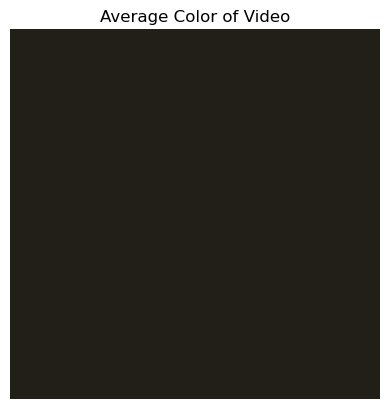

Total frames: 3481
Average movement score: 14.266414119871488
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'mp42', 'minor_version': '0', 'compatible_brands': 'isommp42', 'creation_time': '2023-09-04T00:52:23.000000Z'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [640, 360], 'bitrate': 154, 'fps': 23.976023976023978, 'codec_name': 'h264', 'profile': '(Main)', 'metadata': {'Metadata': '', 'creation_time': '2023-09-04T00:52:23.000000Z', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 09/03/2023.', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': 'eng', 'default': True, 'fps': 44100, 'bitrate': 127, 'metadata': {'Metadata': '', 'creation_time': '2023-09-04T00:52:23.000000Z', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 09/03/2023.', 'vendor_id': '[0][0][0][0]'}}], 'input_number':

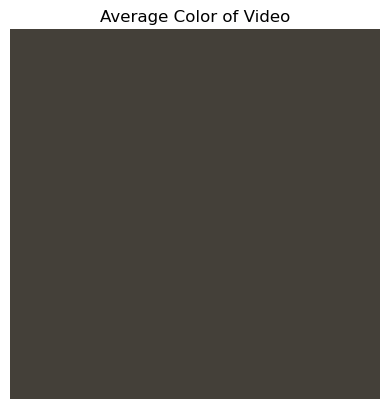

Total frames: 3323
Average movement score: 15.265565510740883
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'mp42', 'minor_version': '0', 'compatible_brands': 'isommp42', 'creation_time': '2025-02-03T07:36:05.000000Z', 'encoder': 'Google'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [640, 360], 'bitrate': 236, 'fps': 23.976023976023978, 'codec_name': 'h264', 'profile': '(Main)', 'metadata': {'Metadata': '', 'creation_time': '2025-02-03T07:36:05.000000Z', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 02/02/2025.', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': 'eng', 'default': True, 'fps': 44100, 'bitrate': 128, 'metadata': {'Metadata': '', 'creation_time': '2025-02-03T07:36:05.000000Z', 'handler_name': 'ISO Media file produced by Google Inc. Created on: 02/02/2025.', 'vendor_id': '[0][0][0][0]

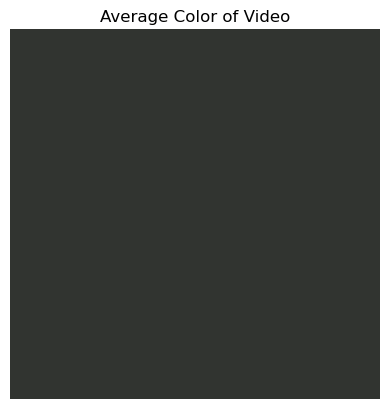

Total frames: 3571
Average movement score: 16.536645590613293
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'title': 'Superbad (2007) Official Trailer - 35mm Scans (4K ProRes) (FLAT) - https://archive.org/details/superbad-trailer-35mm-scans-uhd-prores', 'encoder': 'Lavf58.51.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [854, 480], 'bitrate': 681, 'fps': 24.0, 'codec_name': 'h264', 'profile': '(Main)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 48000, 'bitrate': 74, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 148.79, 'bitrate': 761, 'start': 0.0, 'default_video_input

In [22]:
model, label_encoder = train_genre_classifier()

video_paths = [
    "HacksawRidge.mp4",
    "ToyStory.mp4",
    "Superbad.mp4"
]

df_final_results = process_multiple_trailers(video_paths, model, label_encoder)

print("\n🎬📊 Resultados Finales:")
print(df_final_results)
plot_emotions_summary(df_final_results)